# Data analysis and visualization of gas mileage in my rx8

## Background

I've collected information at each gas fill up for the past few years: the date, miles driven since last fill up, amount of gas pumped into the tank, and the price per gallon. Each time the tank was filled up completely, allowing the average miles per gallon to be computed over the past tank. The pumps probably don't fill the tank up to the exact same amount each time, but it should be roughly close enough.

Modern cars have trip computers that can record a lot more information and give an instantaneous mileage calculation. It would be interesting to have that much data and take different factors into account, such as air temperature, tire pressure, etc. The biggest source of variation in mileage for my driving pattern is likely the number of cold starts in a day, of which I did not collect data.

## Summary of process and tools used

1. Record gas data in spreadsheet, and export as csv file
2. Load csv file into local MySQL database
3. Run Python through Jupyter Notebook
4. Connect to MySQL database using Python
5. Perform data analysis and visualization in Python
6. Control versions and save to Github using Git
7. Done on Mac OS X with Bash shell

## Exploratory data analysis

First we load packages.

In [1]:
import MySQLdb as mdb
import sys
import pandas as pd
import pandas.io.sql
import numpy as np
from numpy import log
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime
import scipy.stats

Next we connect to the MySQL database and load the entire table as a pandas dataframe.

In [2]:
con = mdb.connect(host='localhost', db='mpg_db', read_default_file='~/.my.cnf')
gas_data = pd.read_sql("SELECT * FROM mpg_table", con)
con.close()
###Alternatively, use the following to load the csv directly
#gas_data = pd.read_csv('gas_data.csv', skiprows=1, 
#                       names = ['thedate', 'days', 'odometer', 'miles', 'gallons', 
#                                'cost', 'costpergal', 'station', 'style', 'mpg', 
#                                'mpdol', 'dolpm', 'mpd', 'gpd', 'dolpd']) 
                       ##parse_dates=['thedate'], date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d').date())
                       

#for i in range(0, gas_data['thedate'].size):
#    gas_data['thedate'][i] = datetime.strptime(gas_data['thedate'][i],'%Y-%m-%d').date()

#a quick look at the table
print 'Some quick info on the dataframe:'
#print type(gas_data) #shows type as pandas dataframe
#print(gas_data) #shows the table
print 'Column heads: ', list(gas_data) #shows some info about the fields in the table
print '\nNumber of rows: ',  gas_data.shape[0]

Some quick info on the dataframe:
Column heads:  ['thedate', 'days', 'odometer', 'miles', 'gallons', 'cost', 'costpergal', 'station', 'style', 'mpg', 'mpdol', 'dolpm', 'mpd', 'gpd', 'dolpd']

Number of rows:  114


### Gas prices

Here's a plot of gas prices over time. Costco is significantly cheaper than other stations, so the graph is misleading in general. The second plot distinguishes between stations.

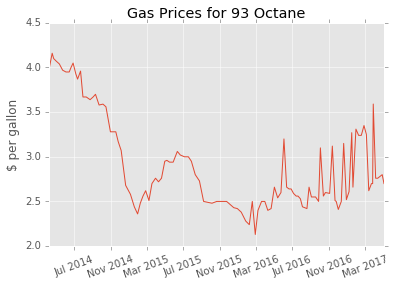

In [3]:
plt.plot_date(matplotlib.dates.date2num(gas_data['thedate']), 
                         gas_data['costpergal'], '-') #time-mpg
plt.title('Gas Prices for 93 Octane')
plt.ylabel('$ per gallon')
plt.xticks(rotation=20)
plt.show()

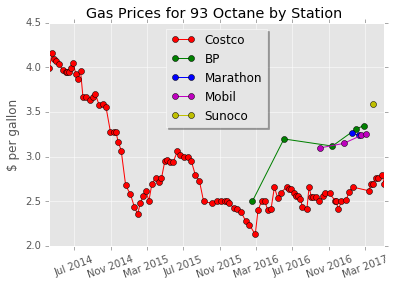

In [4]:
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Costco'].thedate), 
              gas_data[gas_data.station=='Costco'].costpergal, 'r-o', label='Costco')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='BP'].thedate), 
              gas_data[gas_data.station=='BP'].costpergal, 'g-o', label='BP')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Marathon'].thedate), 
              gas_data[gas_data.station=='Marathon'].costpergal, 'b-o', label='Marathon')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Mobil'].thedate), 
              gas_data[gas_data.station=='Mobil'].costpergal, 'm-o', label='Mobil')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Sunoco'].thedate), 
              gas_data[gas_data.station=='Sunoco'].costpergal, 'y-o', label='Sunoco')
#clean this up into a loop
              
#gas_data[gas_data.station=='BP'].plot(x='thedate', y='costpergal', color='blue') 
#pandas wrapper
plt.xticks(rotation=20)
plt.title('Gas Prices for 93 Octane by Station ')
plt.ylabel('$ per gallon')
plt.legend(loc='upper center', shadow='true') #move outside of graph to right
plt.show()

How much cheaper was Costco on average? Let's take a rough estimation by looking at the average price of Costco gas from about January 2017 to March 2017 (where some of the other stations are clustered) and compare it to the average for the other stations over that time span.

In [5]:
starttime = datetime.strptime('2017-01-06','%Y-%m-%d').date() #'2016-09-26'
endtime = datetime.strptime('2017-03-15','%Y-%m-%d').date() #'2017-03-07'
daterange_df = gas_data[(gas_data.thedate>=starttime)  & (gas_data.thedate<=endtime)]
#daterange_df[['thedate', 'station', 'costpergal']]

print 'Mean Costco price: ', round(daterange_df[daterange_df.station=='Costco'].costpergal.mean(), 3)
print 'Mean non-Costco price: ', round(daterange_df[daterange_df.station!='Costco'].costpergal.mean(), 3)
price_diff = daterange_df[daterange_df.station!='Costco'].costpergal.mean()-daterange_df[daterange_df.station=='Costco'].costpergal.mean()
print 'Difference: ', round(price_diff, 3)

#daterange_df[daterange_df.station!='Costco'][['thedate', 'station', 'costpergal']]
#gas_data[['thedate', 'station', 'costpergal']][85:114]

Mean Costco price:  2.629
Mean non-Costco price:  3.276
Difference:  0.647


#### Savings

What can we say about the savings from using Costco on a typical fill-up?

In [6]:
print 'Mean gallons pumped: ', round(gas_data.gallons.mean(), 2)
print 'Rough average of savings per fill-up: $', round(price_diff*gas_data.gallons.mean(), 2)

Mean gallons pumped:  12.71
Rough average of savings per fill-up: $ 8.22


The Costco membership is $\$55$ per year (I think it's going up to $\$60$ now). Either way, I could expect to cover the cost of the member ship after about $7$ fill-ups. On average, I would fill-up after the following number of days.

In [7]:
print 'Days between fill-ups: ', round(gas_data.days.mean(), 2)

Days between fill-ups:  9.9


Therefore, I would cover the membership cost in about $70$ days, or $10$ weeks, if I only filled up at Costco. I could also expect to fill up about $29$ additional times over the course of the year, and so I would the following amount by only filling up at Costco for the rest of the year after paying for the membership.

In [8]:
print 'Savings from using only Costco in a year: $', int(price_diff*gas_data.gallons.mean()*29)

Savings from using only Costco in a year: $ 238


### Gas mileage

Here's are some descriptive statistics about the mpg (miles per gallon).

count    114.000000
mean      14.424821
std        1.419683
min       12.244450
25%       13.363415
50%       14.059650
75%       15.353640
max       18.264600
Name: mpg, dtype: float64


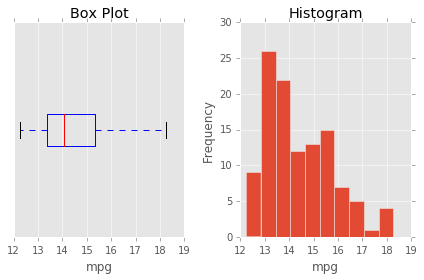

In [9]:
print gas_data.mpg.describe()

plt.subplot(121)
plt.boxplot(gas_data['mpg'],vert=False) #gas_data['mpg'].plot.box()
plt.xlabel('mpg')
plt.yticks([], [])
plt.title('Box Plot')
plt.subplot(122)
gas_data.mpg.plot.hist()
plt.xlabel('mpg')
plt.title('Histogram')
plt.tight_layout()
plt.show()

Now we plot the mileage over time. The vertical line is an event where the tires were changed and it explains the fall in mpg and why the above histogram appears to be bimodal. We'll get to that shortly.

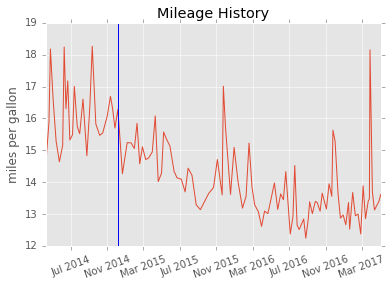

In [10]:
plt.plot_date(matplotlib.dates.date2num(gas_data['thedate']), 
              gas_data['mpg'], '-')
plt.axvline(x=datetime.strptime('2014-12-07','%Y-%m-%d').date())
plt.title('Mileage History')
plt.ylabel('miles per gallon')
plt.xticks(rotation=20)
plt.show()

#### City vs. Mixed Highway driving

We expect there to be mileage differences between city/commute driving and highway driving. In my case I never did any pure highway driving over a full tank in this car since I know the mileage isn't good, therefore, there are only a few instances where I did some highway driving mixed in with my usual commute.

To distinguish between city driving and mixded highway driving, we use the mpd (miles per day) as an indicator of highway driving. The following is a plot of mileage given the number of miles driven per day. 

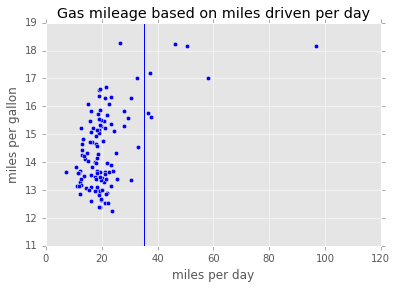

Number of data points past cutoff: 7


In [11]:
plt.scatter(gas_data['mpd'], gas_data['mpg'])
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.title('Gas mileage based on miles driven per day')

cutoff=35 #set cutoff between city and mixed
plt.axvline(cutoff)

plt.show()

print 'Number of data points past cutoff: {}'.format(gas_data[gas_data.mpd>=cutoff].shape[0])

Now let's make two boxplots grouped by city mileage and mixed highway mileage.

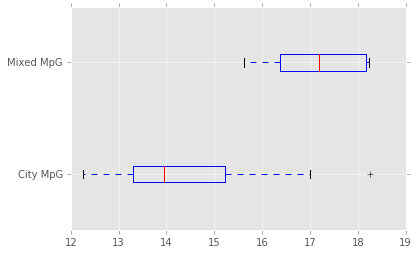

In [12]:
#fig = plt.figure()
#ax = fig.add_subplot(111)
plt.boxplot([gas_data[gas_data.mpd<cutoff].mpg,gas_data[gas_data.mpd>=cutoff].mpg], vert=False)
plt.yticks([1, 2], ['City MpG', 'Mixed MpG'])
plt.show()
#gas_data[(gas_data.mpd>cutoff) & (gas_data.station=='Costco')].mpg
#above shows how to select multiple conditions

##ALSO PLOT OVERLAPPING HISTOGRAMS HERE!

Here's a mileage over time graph for the two different drive styles.

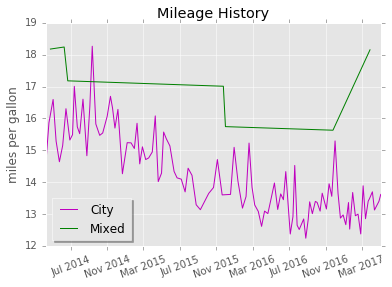

In [13]:
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.mpd<cutoff].thedate), 
              gas_data[gas_data.mpd<cutoff].mpg, 'm-', label='City')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.mpd>=cutoff].thedate), 
              gas_data[gas_data.mpd>=cutoff].mpg, 'g-', label='Mixed')

plt.title('Mileage History')
plt.ylabel('miles per gallon')
plt.legend(loc='lower left', shadow='true')
plt.xticks(rotation=20)
plt.show()

#### New tires

New tires were put on after the December 6th, 2014 fill up. These tires had a stickier compound which reduced the mileage. Let's break some of the previous graphs down into these two categories.

In [14]:
#gas_data[gas_data.thedate<datetime.strptime('2014-12-07','%Y-%m-%d').date()].mpd
#also consider num2date from matplotlib
tire_date=datetime.strptime('2014-12-07','%Y-%m-%d').date() #when tires were changed

print gas_data[gas_data.thedate<tire_date].mpg.describe()
print '\n'
print gas_data[gas_data.thedate>=tire_date].mpg.describe()
print '\n'
mpg_diff = gas_data[gas_data.thedate<tire_date].mpg.mean()-gas_data[gas_data.thedate>=tire_date].mpg.mean()
print 'Difference in means: ', round(mpg_diff, 2)

count    27.000000
mean     16.116097
std       1.009815
min      14.631160
25%      15.479905
50%      15.865500
75%      16.599920
max      18.264600
Name: mpg, dtype: float64


count    87.000000
mean     13.899942
std       1.078538
min      12.244450
25%      13.133330
50%      13.633770
75%      14.482560
max      18.151940
Name: mpg, dtype: float64


Difference in means:  2.22


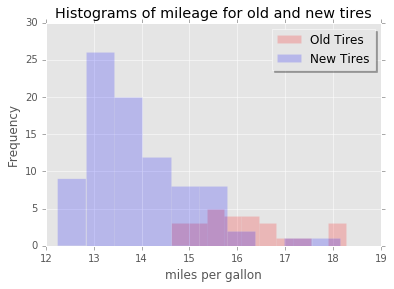

In [15]:
#fig = plt.figure()
#ax = fig.add_subplot(121)
gas_data[gas_data.thedate<tire_date].mpg.plot.hist(color='red', alpha=0.20, label='Old Tires')
#ax = fig.add_subplot(122)
gas_data[gas_data.thedate>=tire_date].mpg.plot.hist(color='blue', alpha=0.20, label='New Tires')
plt.title('Histograms of mileage for old and new tires')
plt.xlabel('miles per gallon')
plt.legend(loc='upper right', shadow='true')
plt.show()

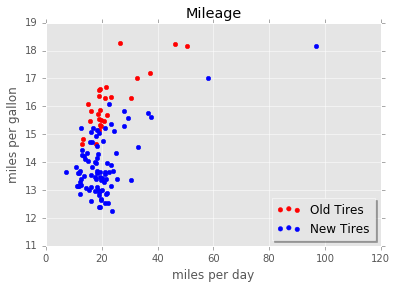

In [16]:
plt.scatter(gas_data[gas_data.thedate<tire_date].mpd, 
            gas_data[gas_data.thedate<tire_date].mpg, 
            color='red', label='Old Tires')
plt.scatter(gas_data[gas_data.thedate>tire_date].mpd, 
            gas_data[gas_data.thedate>tire_date].mpg, 
            color='blue', label='New Tires')
plt.title('Mileage')
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.legend(loc='lower right', shadow='true')
plt.show()

Let's look at box plots comparing the old and new tires now with different driving conditions.

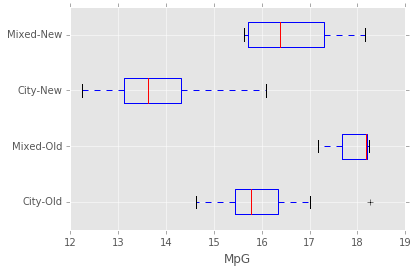

In [17]:
plt.boxplot([gas_data[(gas_data.mpd<cutoff)  & (gas_data.thedate<tire_date)].mpg, 
             gas_data[(gas_data.mpd>=cutoff) & (gas_data.thedate<tire_date)].mpg, 
             gas_data[(gas_data.mpd<cutoff)  & (gas_data.thedate>tire_date)].mpg,
             gas_data[(gas_data.mpd>=cutoff) & (gas_data.thedate>tire_date)].mpg
            ], vert=False)
plt.yticks([1, 2, 3, 4], ['City-Old', 'Mixed-Old', 'City-New', 'Mixed-New'])
plt.xlabel('MpG')
plt.show()

Here's Welch's t-test which tests the signficance of the possibility that the means could be drawn from the same population. As you can tell from the pictures, it looks pretty significant that they're different. We also look at the Kolmogorov-Smirnov (KS) two-sample test which tells us how likely it is that the two distributions are the same.

In [18]:
#Welch's t-test, or unequal variances t-test, is a two-sample location test which is used to 
#test the hypothesis that two populations have equal means.
#Welch's t-test is more robust than Student's t-test and maintains type I error rates 
#close to nominal for unequal variances and for unequal sample sizes.

print scipy.stats.ttest_ind(gas_data[gas_data.thedate<tire_date].mpg, 
                            gas_data[gas_data.thedate>=tire_date].mpg, equal_var=False)
print 'Taking a smaller sample out of the new tires:'
print scipy.stats.ttest_ind(gas_data[gas_data.thedate<tire_date].mpg, 
                            gas_data[gas_data.thedate>=tire_date].mpg.sample(n=30), equal_var=False)


#Note that the two-sample test checks whether the two data samples come from the same distribution. 
#This does not specify what that common distribution is (e.g. whether it's normal or not normal).

print '\nHere we compare the two distributions directly with the KS test:'
print scipy.stats.ks_2samp(gas_data[gas_data.thedate<tire_date].mpg, 
                         gas_data[gas_data.thedate>=tire_date].mpg)
print 'Here we compare the two distributions restricted to city driving:'
print scipy.stats.ks_2samp(gas_data[(gas_data.mpd<cutoff)  & (gas_data.thedate<tire_date)].mpg, 
                           gas_data[(gas_data.mpd<cutoff)  & (gas_data.thedate>=tire_date)].mpg)



Ttest_indResult(statistic=9.8000287124073324, pvalue=7.8382049025200846e-13)
Taking a smaller sample out of the new tires:
Ttest_indResult(statistic=8.1038273146675248, pvalue=7.0445101395756715e-11)

Here we compare the two distributions directly with the KS test:
Ks_2sampResult(statistic=0.77011494252873558, pvalue=1.0027061879953221e-11)
Here we compare the two distributions restricted to city driving:
Ks_2sampResult(statistic=0.80722891566265065, pvalue=1.1003249939569052e-11)


#### Potential Savings

Here's a quick estimate of how much the new tires with their worse mileage cost me compared to if I had just stayed with the old brand upon replacement. I put the new tires on at about $20,000$ miles, and I'm up to about $36,000$ miles now. As seen earlier, the mean mpgs were about $16.1$ mpg vs. $13.9$ mpg. So for $16,000$ miles, this amount of gallons was used,

In [19]:
print round(16000*(1/13.9-1/16.1), 2)

157.29


The average gas price during that time was,

In [20]:
print round(gas_data[(gas_data.thedate>=tire_date)].costpergal.mean(), 2)

2.68


So I spent about $2.68*157.29\approx\$421$ extra on gas by using this brand of new tires, so far. 

The original tires were also summer performance tires, and I hypothesize that fuel efficient low rolling resistance tires would gain me an extra $2$ mpg on top of them, for about $18$ mpg on average. So had I used those hypothetical tires instead, over the same time I would have saved the following amount of dollars,

In [21]:
print '$', round(16000*(1/13.9-1/18.1)*gas_data[(gas_data.thedate>=tire_date)].costpergal.mean(), 2)

$ 716.76


The new tires have been on for about 2.5 years, so I could've saved the following per year.

In [22]:
print '$', round(16000*(1/13.9-1/18.1)*gas_data[(gas_data.thedate>=tire_date)].costpergal.mean()/2.5, 2)

$ 286.71


## Regression analysis

Here we run a linear regression using the statsmodel library.

In [23]:
regression = smf.ols(formula = 'mpg ~ mpd', data = gas_data).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     44.47
Date:                Wed, 07 Jun 2017   Prob (F-statistic):           1.02e-09
Time:                        19:42:52   Log-Likelihood:                -182.15
No. Observations:                 114   AIC:                             368.3
Df Residuals:                     112   BIC:                             373.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9140      0.253     51.011      0.0

Here's an alternative method to get some regression data using the scikit library.

In [24]:
mpg_data2 = gas_data[['mpg']]
mpd_data2 = gas_data[['mpd']]
sk_regr = linear_model.LinearRegression()
sk_regr.fit(mpd_data2, mpg_data2)
print 'coefficient: {0:.4f}'.format(sk_regr.coef_[0][0])
print 'intercept: {0:.4f}'.format(sk_regr.intercept_[0])
print 'R-squared: {0:.3f}'.format(sk_regr.score(mpd_data2, mpg_data2))

coefficient: 0.0723
intercept: 12.9140
R-squared: 0.284


We can see the data matches up with both methods. This linear model isn't a great fit, as indicated by the R-squared value. Let's plot it over the scatter plot from earlier.

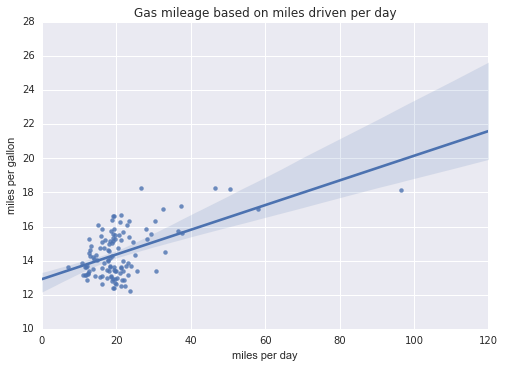

In [25]:
import seaborn as sns
sns.regplot(gas_data['mpd'], gas_data['mpg']) #with seaborn
#next two lines would plot the line directly
#x = np.arange(0, 100)
#plt.plot(sk_regr.coef_[0][0]*x+sk_regr.intercept_[0], 'r')
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.title('Gas mileage based on miles driven per day')
plt.show()

Here's a locally weighted model.

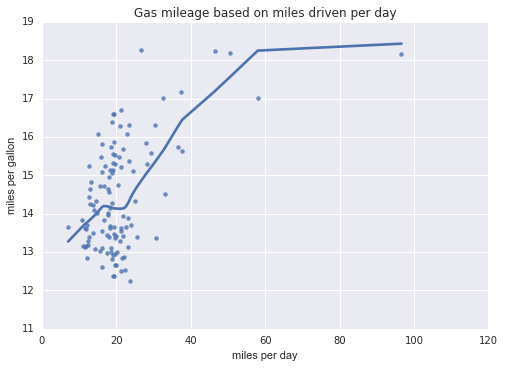

In [26]:
sns.regplot(gas_data['mpd'], gas_data['mpg'], lowess=True)
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.title('Gas mileage based on miles driven per day')
plt.show()

Let's plot two lines based on the old and new tires.

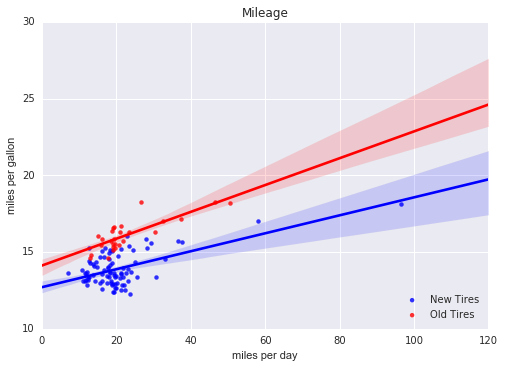

In [27]:
sns.regplot(gas_data[gas_data.thedate>tire_date].mpd, 
            gas_data[gas_data.thedate>tire_date].mpg,
            color='blue', label='New Tires')
sns.regplot(gas_data[gas_data.thedate<tire_date].mpd, 
            gas_data[gas_data.thedate<tire_date].mpg,
            color='red', label='Old Tires')
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.title('Mileage')
plt.legend(loc='lower right')
plt.show()

And here's the locally weighted models.

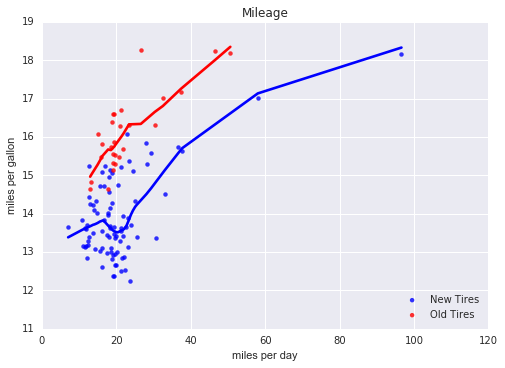

In [28]:
sns.regplot(gas_data[gas_data.thedate>tire_date].mpd, 
            gas_data[gas_data.thedate>tire_date].mpg,
            color='blue', label='New Tires', lowess=True)
sns.regplot(gas_data[gas_data.thedate<tire_date].mpd, 
            gas_data[gas_data.thedate<tire_date].mpg,
            color='red', label='Old Tires', lowess=True)
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.title('Mileage')
plt.legend(loc='lower right')
plt.show()

Here's some linear regression information for the old and new tires done separately. It looks like we have a better result for the old tires based on the R-squared values.

In [29]:
print'Old Tires'
mpg_data_O = gas_data[gas_data.thedate<tire_date][['mpg']]
mpd_data_O = gas_data[gas_data.thedate<tire_date][['mpd']]
sk_regr_O = linear_model.LinearRegression()
sk_regr_O.fit(mpd_data_O, mpg_data_O)
print 'coefficient: {0:.4f}'.format(sk_regr_O.coef_[0][0])
print 'intercept: {0:.4f}'.format(sk_regr_O.intercept_[0])
print 'R-squared: {0:.3f}'.format(sk_regr_O.score(mpd_data_O, mpg_data_O))

print '\n' + 'New Tires'
mpg_data_N = gas_data[gas_data.thedate>tire_date][['mpg']]
mpd_data_N = gas_data[gas_data.thedate>tire_date][['mpd']]
sk_regr_N = linear_model.LinearRegression()
sk_regr_N.fit(mpd_data_N, mpg_data_N)
print 'coefficient: {0:.4f}'.format(sk_regr_N.coef_[0][0])
print 'intercept: {0:.4f}'.format(sk_regr_N.intercept_[0])
print 'R-squared: {0:.3f}'.format(sk_regr_N.score(mpd_data_N, mpg_data_N))

Old Tires
coefficient: 0.0874
intercept: 14.1235
R-squared: 0.638

New Tires
coefficient: 0.0585
intercept: 12.7123
R-squared: 0.343


In [30]:
#We can also try a log model, however the fit appears to be even worse.
#gas_data['log_mpd'] = log(gas_data['mpd'])
#gas_data['log_mpg'] = log(gas_data['mpg'])
#log_lm = smf.ols(formula = 'log_mpg ~ log_mpd', data = gas_data).fit()
#print(log_lm.summary())

## Actionable Insights/Bottom-line

Filling up only at Costco would save me about $\$240$ per year after the cost of membership, given my driving pattern, which is only about $6,600$ miles per year of mostly city driving. Installing low rolling resistance tires would be expected to save me roughly $\$290$ a year over my current tires. The total savings from cheap gas and fuel efficient tires would be $\$530$. I drive a relatively low number of miles, so someone who drives more could stand to save a lot with those choices.

We also saw that the relation between highway vs. city driving could be seen in the data through the graphs and regression models. An increase in the miles per day corresponds to an increase in miles per gallon as one would expect.